In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# test_data_dir = '../examples/PyMPDATA_examples/Arabas_and_Farhat_2020/data/'
train_data_dir = './data/'

In [3]:
def load_data(filepath, idx):
    data = []
    for i in tqdm(range(idx)):
        advector = np.load(filepath + 'advector_' + str(i) + '.npy')
        advectee = np.load(filepath + 'advectee_' + str(i) + '.npy')
        flux = np.load(filepath + 'corrective_flux_' + str(i) + '.npy')
        data.append([advector, advectee, -flux])
        
    for i in tqdm(range(idx)):
        data[i][1] = pd.DataFrame(data[i][1]).fillna(method='ffill').values
        data[i][0] = pd.DataFrame(data[i][0]).fillna(method='ffill').values
        data[i][2] = pd.DataFrame(data[i][2]).fillna(method='ffill').values
        data[i][1] = pd.DataFrame(data[i][1]).fillna(method='bfill').values
        data[i][0] = pd.DataFrame(data[i][0]).fillna(method='bfill').values
        data[i][2] = pd.DataFrame(data[i][2]).fillna(method='bfill').values
    return data

In [4]:
data_train = load_data(train_data_dir, 20000)

In [9]:
import pickle
with open('data_train.pkl', 'wb') as f:
    pickle.dump(data_train, f)

In [10]:
def get_stencils(data, stencil_length):
    stencils= []
    max_advector = max(data[:][0].max() for data in data)
    max_advectee = max(data[:][1].max() for data in data)
    max_flux = max(data[:][2].max() for data in data)
    # print(f"max_advector: {max_advector}, max_advectee: {max_advectee}, max_flux: {max_flux}")
    for i in range(len(data)):
        advector, advectee, flux = data[i]
        for j in range(0, len(data[i][1])-1):
            advectee_stencil = advectee[j-1:j+1]
            advector_stencil = advector[j-1:j+2]
            flux_stencil = flux[j]
            if np.isnan(advectee_stencil).any() or np.isnan(advector_stencil).any() or np.isnan(flux_stencil).any():
                continue
            try:
                assert advectee_stencil.shape[0] == stencil_length -1
                assert advector_stencil.shape[0] == stencil_length
            except:
                # print(advectee_stencil.shape[0], advector_stencil.shape[0])
                # print(advectee_stencil)
                # print(advector_stencil)
                # print(flux_stencil)
                # print()
                continue
            # if any of the values are nan, skip this stencil
            advector_stencil = advector_stencil / max_advector
            # flatten the stencil
            advector_stencil = advector_stencil.flatten()
            advectee_stencil = advectee_stencil / max_advectee
            advectee_stencil = advectee_stencil.flatten()
            flux_stencil = flux_stencil / max_flux
            # flatten the stencil
            flux_stencil = flux_stencil.flatten()
            input_stencil = np.concatenate((advector_stencil, advectee_stencil), axis=0)

            stencils.append((input_stencil, flux_stencil[0]))
    return stencils

In [11]:
train_stencils = get_stencils(data_train, 3)

In [20]:
df_train = pd.DataFrame(train_stencils, columns=['input', 'flux'])

In [13]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

def get_model(n_hidden_layers, n_neurons, n_inputs=5):
    model = keras.Sequential()
    # add the input layer
    model.add(layers.Dense(n_neurons, activation='relu', input_shape=(n_inputs,)))
    for i in range(n_hidden_layers):
        model.add(layers.Dense(n_neurons, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

def train_model(model, df_train, df_test, epochs=100):
    X_train = df_train['input'].values
    y_train = df_train['flux'].values
    X_test = df_test['input'].values
    y_test = df_test['flux'].values
    X_train, y_train = np.stack(X_train), np.stack(y_train)
    X_test, y_test = np.stack(X_test), np.stack(y_test)
    history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test), batch_size=32)
    return model, history

def visualize_training(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.yscale('log')
    plt.show()
    
def visualize_output(model, val_data):
    X_test = val_data['input']
    y_test = val_data['flux']
    X_test, y_test = np.stack(X_test), np.stack(y_test)
    outputs = model.predict(X_test)
    output = np.concatenate(outputs)
    plt.plot(output)
    plt.plot(y_test)
    plt.legend(['output', 'y_test'])
    plt.show()
    


Epoch 1/200
32/32 [==============================] - 1s 8ms/step - loss: 0.3412 - val_loss: 0.2971
Epoch 2/200
32/32 [==============================] - 0s 4ms/step - loss: 0.2715 - val_loss: 0.2148
Epoch 3/200
32/32 [==============================] - 0s 4ms/step - loss: 0.2036 - val_loss: 0.1537
Epoch 4/200
32/32 [==============================] - 0s 3ms/step - loss: 0.1574 - val_loss: 0.1089
Epoch 5/200
32/32 [==============================] - 0s 3ms/step - loss: 0.1202 - val_loss: 0.0735
Epoch 6/200
32/32 [==============================] - 0s 3ms/step - loss: 0.0927 - val_loss: 0.0477
Epoch 7/200
32/32 [==============================] - 0s 3ms/step - loss: 0.0748 - val_loss: 0.0362
Epoch 8/200
32/32 [==============================] - 0s 3ms/step - loss: 0.0649 - val_loss: 0.0255
Epoch 9/200
32/32 [==============================] - 0s 3ms/step - loss: 0.0571 - val_loss: 0.0189
Epoch 10/200
32/32 [==============================] - 0s 3ms/step - loss: 0.0517 - val_loss: 0.0150
Epoch 11/

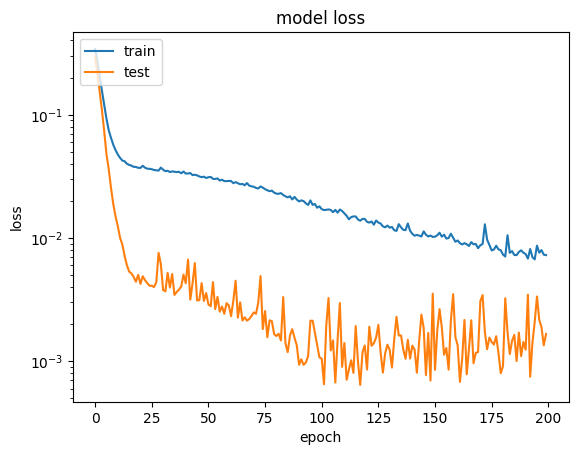

4/4 [==============================] - 0s 1ms/step


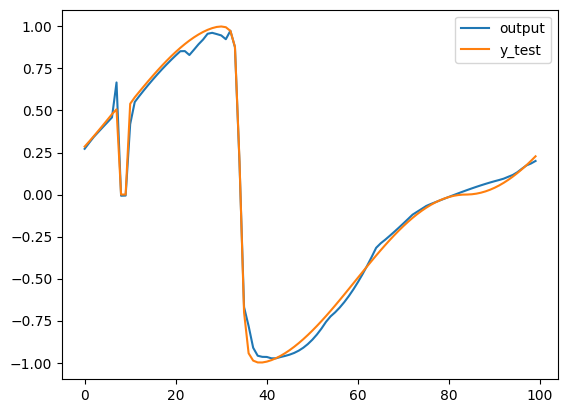

In [26]:
model = get_model(n_hidden_layers=2, n_neurons=10)
df_test = df_train[-100:]
df_train = df_train[:1500]
model, history = train_model(model, df_train, df_test, epochs=200)
visualize_training(history)
visualize_output(model, df_test)
model.save('model.h5')

Epoch 1/200
313/313 [==============================] - 1s 2ms/step - loss: 0.0918 - val_loss: 0.0340
Epoch 2/200
313/313 [==============================] - 0s 2ms/step - loss: 0.0079 - val_loss: 0.0358
Epoch 3/200
313/313 [==============================] - 0s 2ms/step - loss: 0.0072 - val_loss: 0.0338
Epoch 4/200
313/313 [==============================] - 0s 1ms/step - loss: 0.0063 - val_loss: 0.0362
Epoch 5/200
313/313 [==============================] - 0s 1ms/step - loss: 0.0053 - val_loss: 0.0352
Epoch 6/200
313/313 [==============================] - 0s 1ms/step - loss: 0.0047 - val_loss: 0.0338
Epoch 7/200
313/313 [==============================] - 0s 1ms/step - loss: 0.0045 - val_loss: 0.0340
Epoch 8/200
313/313 [==============================] - 0s 1ms/step - loss: 0.0043 - val_loss: 0.0349
Epoch 9/200
313/313 [==============================] - 0s 2ms/step - loss: 0.0043 - val_loss: 0.0346
Epoch 10/200
313/313 [==============================] - 0s 1ms/step - loss: 0.0042 - val_lo

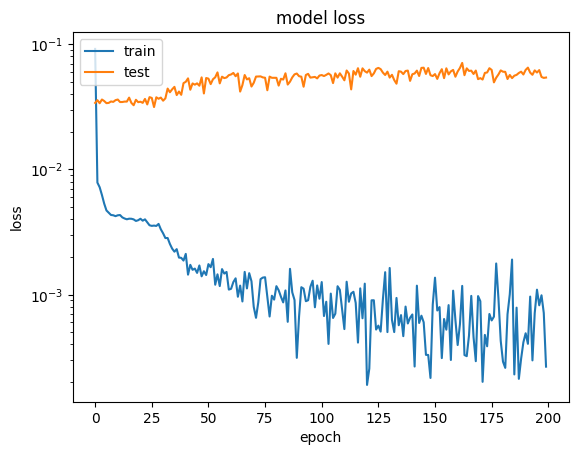

4/4 [==============================] - 0s 1ms/step


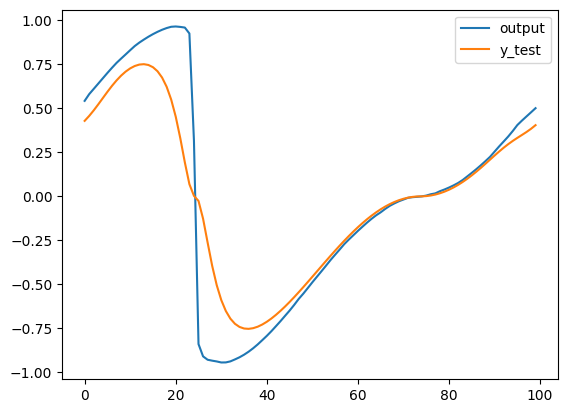

In [21]:
df_train = pd.DataFrame(train_stencils, columns=['input', 'flux'])
model = get_model(n_hidden_layers=4, n_neurons=20)
df_test = df_train[-1000:]
df_train = df_train[:10000]
model, history = train_model(model, df_train, df_test, epochs=200)
visualize_training(history)
visualize_output(model, df_test[-100:])
model.save('model2.h5')

Epoch 1/50
313/313 [==============================] - 1s 2ms/step - loss: 0.2089 - val_loss: 0.0178
Epoch 2/50
313/313 [==============================] - 0s 1ms/step - loss: 0.0201 - val_loss: 0.0286
Epoch 3/50
313/313 [==============================] - 0s 1ms/step - loss: 0.0117 - val_loss: 0.0319
Epoch 4/50
313/313 [==============================] - 0s 1ms/step - loss: 0.0090 - val_loss: 0.0342
Epoch 5/50
313/313 [==============================] - 0s 1ms/step - loss: 0.0078 - val_loss: 0.0369
Epoch 6/50
313/313 [==============================] - 0s 1ms/step - loss: 0.0069 - val_loss: 0.0390
Epoch 7/50
313/313 [==============================] - 0s 1ms/step - loss: 0.0063 - val_loss: 0.0395
Epoch 8/50
313/313 [==============================] - 0s 1ms/step - loss: 0.0056 - val_loss: 0.0392
Epoch 9/50
313/313 [==============================] - 0s 1ms/step - loss: 0.0053 - val_loss: 0.0385
Epoch 10/50
313/313 [==============================] - 0s 1ms/step - loss: 0.0049 - val_loss: 0.0380

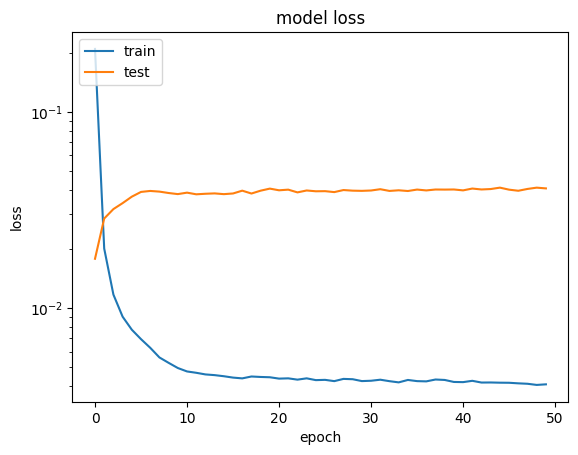

4/4 [==============================] - 0s 2ms/step


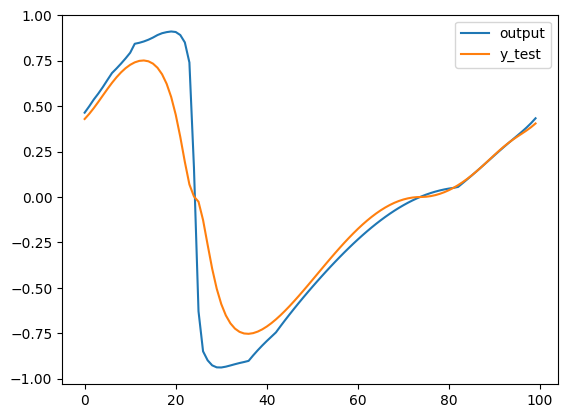

In [22]:
df_train = pd.DataFrame(train_stencils, columns=['input', 'flux'])
model = get_model(n_hidden_layers=3, n_neurons=5)
df_test = df_train[-1000:]
df_train = df_train[:10000]
model, history = train_model(model, df_train, df_test, epochs=50)
visualize_training(history)
visualize_output(model, df_test[-100:])
model.save('model3.h5')

Epoch 1/30
313/313 [==============================] - 1s 2ms/step - loss: 0.3114 - val_loss: 0.1459
Epoch 2/30
313/313 [==============================] - 0s 2ms/step - loss: 0.0890 - val_loss: 0.0493
Epoch 3/30
313/313 [==============================] - 0s 2ms/step - loss: 0.0359 - val_loss: 0.0208
Epoch 4/30
313/313 [==============================] - 0s 2ms/step - loss: 0.0179 - val_loss: 0.0102
Epoch 5/30
313/313 [==============================] - 0s 1ms/step - loss: 0.0114 - val_loss: 0.0066
Epoch 6/30
313/313 [==============================] - 0s 2ms/step - loss: 0.0089 - val_loss: 0.0048
Epoch 7/30
313/313 [==============================] - 0s 2ms/step - loss: 0.0078 - val_loss: 0.0040
Epoch 8/30
313/313 [==============================] - 0s 2ms/step - loss: 0.0072 - val_loss: 0.0039
Epoch 9/30
313/313 [==============================] - 0s 2ms/step - loss: 0.0067 - val_loss: 0.0034
Epoch 10/30
313/313 [==============================] - 0s 2ms/step - loss: 0.0063 - val_loss: 0.0042

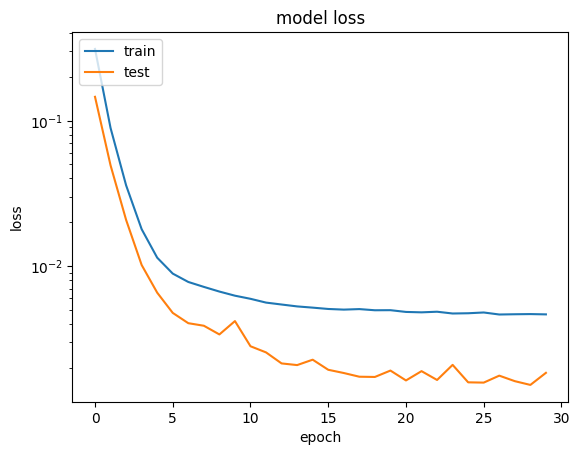

4/4 [==============================] - 0s 1ms/step


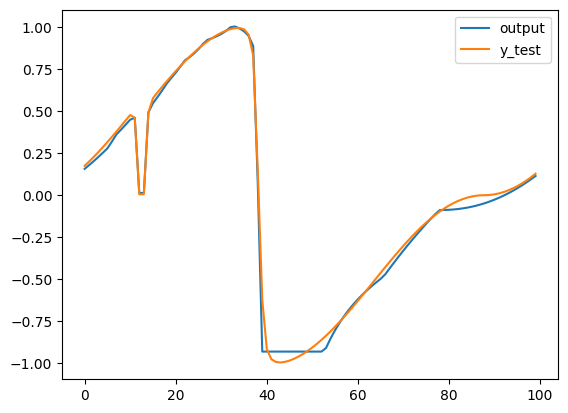

In [26]:
df_train = pd.DataFrame(train_stencils, columns=['input', 'flux'])
model = get_model(n_hidden_layers=3, n_neurons=5)
df_test = df_train[10500:11500]
df_train = df_train[:10000]
model, history = train_model(model, df_train, df_test, epochs=30)
visualize_training(history)
visualize_output(model, df_test[-100:])
model.save('model4.h5')

Epoch 1/30
313/313 [==============================] - 1s 2ms/step - loss: 0.0727 - val_loss: 0.0059
Epoch 2/30
313/313 [==============================] - 0s 2ms/step - loss: 0.0089 - val_loss: 0.0037
Epoch 3/30
313/313 [==============================] - 0s 1ms/step - loss: 0.0074 - val_loss: 0.0028
Epoch 4/30
313/313 [==============================] - 0s 1ms/step - loss: 0.0066 - val_loss: 0.0041
Epoch 5/30
313/313 [==============================] - 0s 1ms/step - loss: 0.0056 - val_loss: 0.0012
Epoch 6/30
313/313 [==============================] - 0s 2ms/step - loss: 0.0048 - val_loss: 6.3437e-04
Epoch 7/30
313/313 [==============================] - 0s 2ms/step - loss: 0.0045 - val_loss: 6.2667e-04
Epoch 8/30
313/313 [==============================] - 0s 2ms/step - loss: 0.0043 - val_loss: 6.8245e-04
Epoch 9/30
313/313 [==============================] - 0s 2ms/step - loss: 0.0042 - val_loss: 0.0015
Epoch 10/30
313/313 [==============================] - 0s 2ms/step - loss: 0.0042 - val_

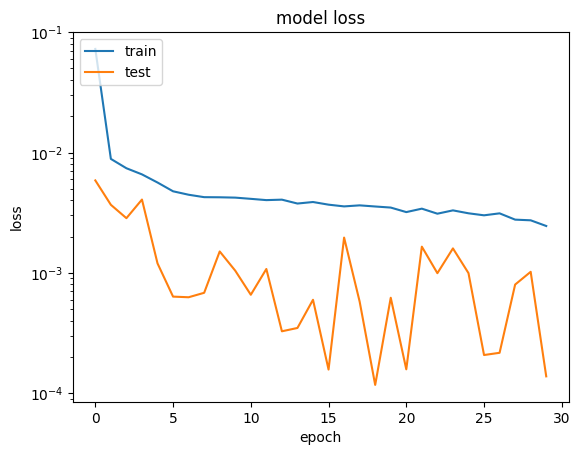

4/4 [==============================] - 0s 1ms/step


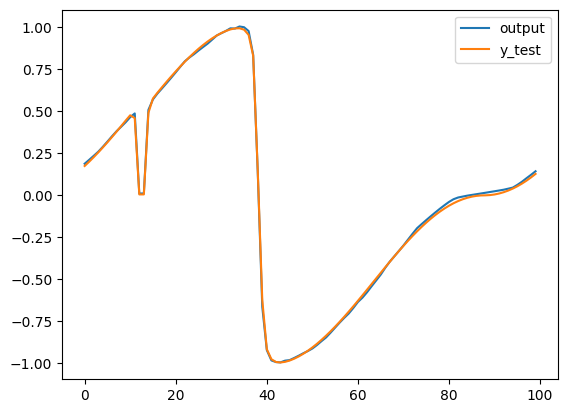

In [27]:
df_train = pd.DataFrame(train_stencils, columns=['input', 'flux'])
model = get_model(n_hidden_layers=4, n_neurons=20)
df_test = df_train[10500:12500]
df_train = df_train[:10000]
model, history = train_model(model, df_train, df_test, epochs=30)
visualize_training(history)
visualize_output(model, df_test[-100:])
model.save('model5.h5')

RangeIndex(start=0, stop=10000, step=1)
RangeIndex(start=11000, stop=13000, step=1)
Epoch 1/200
313/313 [==============================] - 1s 2ms/step - loss: 0.0599 - val_loss: 0.0035
Epoch 2/200
313/313 [==============================] - 0s 2ms/step - loss: 0.0065 - val_loss: 0.0016
Epoch 3/200
313/313 [==============================] - 0s 2ms/step - loss: 0.0059 - val_loss: 0.0023
Epoch 4/200
313/313 [==============================] - 0s 2ms/step - loss: 0.0054 - val_loss: 0.0013
Epoch 5/200
313/313 [==============================] - 0s 2ms/step - loss: 0.0051 - val_loss: 6.4149e-04
Epoch 6/200
313/313 [==============================] - 1s 2ms/step - loss: 0.0046 - val_loss: 0.0012
Epoch 7/200
313/313 [==============================] - 1s 2ms/step - loss: 0.0045 - val_loss: 4.7247e-04
Epoch 8/200
313/313 [==============================] - 1s 2ms/step - loss: 0.0045 - val_loss: 0.0014
Epoch 9/200
313/313 [==============================] - 1s 2ms/step - loss: 0.0043 - val_loss: 3.7740

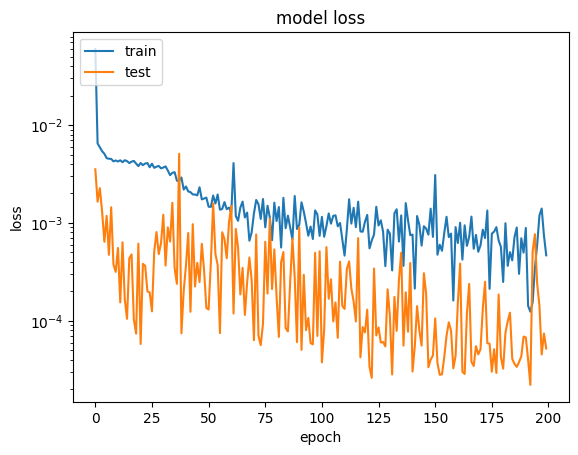

4/4 [==============================] - 0s 1ms/step


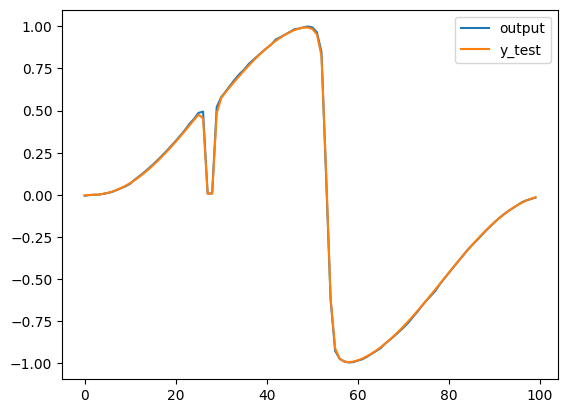

In [29]:
df_train = pd.DataFrame(train_stencils, columns=['input', 'flux'])
model = get_model(n_hidden_layers=4, n_neurons=20)
df_test = df_train[11000:13000]
df_train = df_train[:10000]
print(df_train.index)
print(df_test.index)
model, history = train_model(model, df_train, df_test, epochs=200)
visualize_training(history)
visualize_output(model, df_test[-100:])
model.save('model6.h5')

RangeIndex(start=0, stop=10000, step=1)
RangeIndex(start=11000, stop=13000, step=1)
Epoch 1/200
313/313 [==============================] - 1s 2ms/step - loss: 0.2290 - val_loss: 0.1092
Epoch 2/200
313/313 [==============================] - 0s 1ms/step - loss: 0.0766 - val_loss: 0.0454
Epoch 3/200
313/313 [==============================] - 0s 1ms/step - loss: 0.0376 - val_loss: 0.0230
Epoch 4/200
313/313 [==============================] - 0s 1ms/step - loss: 0.0233 - val_loss: 0.0143
Epoch 5/200
313/313 [==============================] - 0s 1ms/step - loss: 0.0174 - val_loss: 0.0106
Epoch 6/200
313/313 [==============================] - 0s 1ms/step - loss: 0.0147 - val_loss: 0.0087
Epoch 7/200
313/313 [==============================] - 0s 1ms/step - loss: 0.0127 - val_loss: 0.0068
Epoch 8/200
313/313 [==============================] - 0s 1ms/step - loss: 0.0105 - val_loss: 0.0053
Epoch 9/200
313/313 [==============================] - 0s 1ms/step - loss: 0.0092 - val_loss: 0.0043
Epoch 1

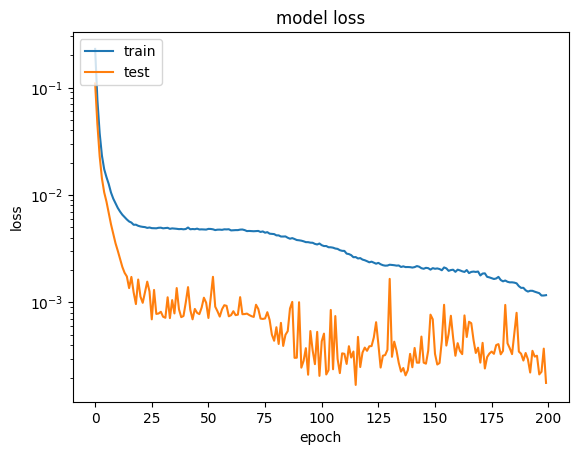

4/4 [==============================] - 0s 2ms/step


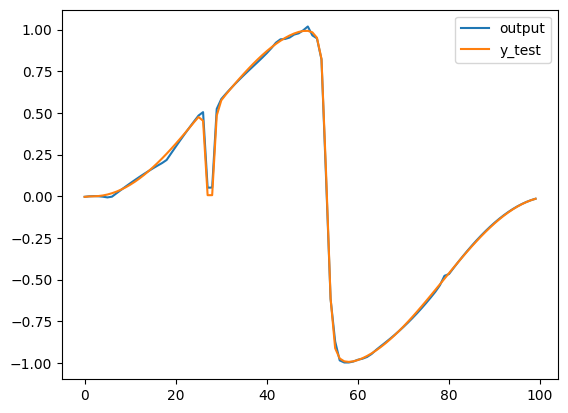

In [30]:
df_train = pd.DataFrame(train_stencils, columns=['input', 'flux'])
model = get_model(n_hidden_layers=2, n_neurons=5)
df_test = df_train[11000:13000]
df_train = df_train[:10000]
print(df_train.index)
print(df_test.index)
model, history = train_model(model, df_train, df_test, epochs=200)
visualize_training(history)
visualize_output(model, df_test[-100:])
model.save('model7.h5')

Epoch 1/200
313/313 [==============================] - 1s 2ms/step - loss: 0.0011 - val_loss: 4.3416e-04
Epoch 2/200
313/313 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 3.3400e-04
Epoch 3/200
313/313 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 2.8892e-04
Epoch 4/200
313/313 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 2.2181e-04
Epoch 5/200
313/313 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 4.0425e-04
Epoch 6/200
313/313 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 3.6012e-04
Epoch 7/200
313/313 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 4.1310e-04
Epoch 8/200
313/313 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 4.0456e-04
Epoch 9/200
313/313 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 5.9292e-04
Epoch 10/200
313/313 [==============================] -

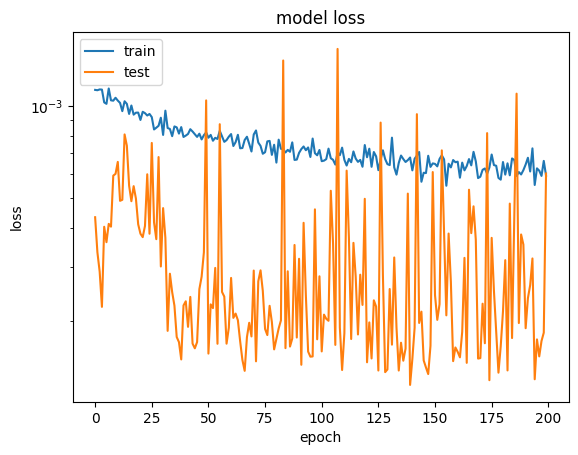

4/4 [==============================] - 0s 1ms/step


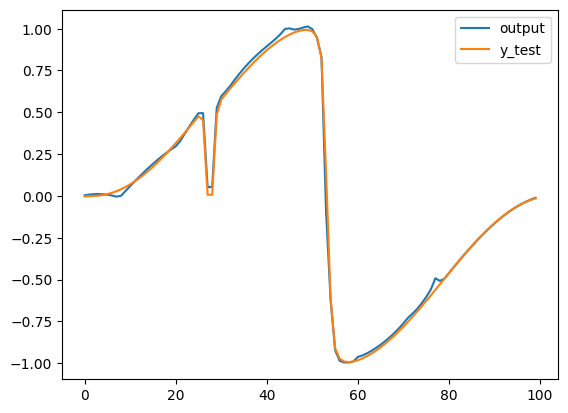

In [31]:
# further training
model, history = train_model(model, df_train, df_test, epochs=200)
visualize_training(history)
visualize_output(model, df_test[-100:])
model.save('model8.h5')

conclusions:
- out of domain predictions are trash
- even very small models yield good results

TODO:
- add data loading from pkl
- make sure that normalizing factors are calculated from train set only (not from test set)
-  